In [13]:
from xml.etree import ElementTree

annotation = ElementTree.parse("dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml")
annotation


In [14]:
annotation.findall("object")


[<Element 'object' at 0x7fb966bbb9f0>, <Element 'object' at 0x7fb966bbbc20>]

In [15]:
for obj in annotation.findall("object"):
    bounding_box = obj.find("bndbox")
    xmin = bounding_box.find("xmin")
    print(xmin.text)


53
158


In [16]:
label_name_to_num = {
    "aeroplane": 0,
    "bicycle": 1,
    "bird": 2,
    "boat": 3,
    "bottle": 4,
    "bus": 5,
    "car": 6,
    "cat": 7,
    "chair": 8,
    "cow": 9,
    "diningtable": 10,
    "dog": 11,
    "horse": 12,
    "motorbike": 13,
    "person": 14,
    "pottedplant": 15,
    "sheep": 16,
    "sofa": 17,
    "train": 18,
    "tvmonitor": 19,
}


In [17]:
def get_center_points(file_path, label_name_to_num):
    annotation = ElementTree.parse(file_path)

    def center(bounding_box):
        xmin = int(bounding_box.find("xmin").text)
        xmax = int(bounding_box.find("xmax").text)
        ymin = int(bounding_box.find("ymin").text)
        ymax = int(bounding_box.find("ymax").text)
        return ((ymin + ymax) // 2, (xmin + xmax) // 2)

    def label_num(name):
        return label_name_to_num[name.text]

    centers = [
        (*center(obj.find("bndbox")), label_num(obj.find("name")))
        for obj in annotation.findall("object")
    ]
    return centers


get_center_points(
    "dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", label_name_to_num
)


[(253, 262, 12), (105, 223, 14)]

In [18]:
import numpy as np


def get_image_size(file_path):
    annotation = ElementTree.parse(file_path)
    size = annotation.find("size")
    width = int(size.find("width").text)
    height = int(size.find("height").text)
    return (height, width)


get_image_size("dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml")


(442, 500)

In [19]:
import numpy as np


def get_raw_label(file_path, label_name_to_num, image_size=None):
    centers = get_center_points(file_path, label_name_to_num)
    if image_size is None:
        image_size = get_image_size(file_path)
    else:
        real_image_size = get_image_size(file_path)
        centers = [
            (
                int(y * (image_size[0] / real_image_size[0])),
                int(x * ( image_size[1] / real_image_size[1])),
                c,
            )
            for y, x, c in centers
        ]
    out = np.zeros((*image_size, len(label_name_to_num)))
    for center in centers:
        out[center[0], center[1], center[2]] = 1
    return out


sample_raw_label = get_raw_label(
    "dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", label_name_to_num
)

print(sample_raw_label.shape)
np.where(sample_raw_label == 1)


(442, 500, 20)


(array([105, 253]), array([223, 262]), array([14, 12]))

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


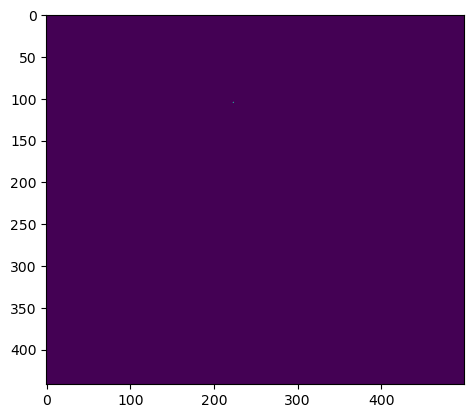

In [20]:
import matplotlib.pyplot as plt

plt.imshow(sample_raw_label[:, :, 14])
print(sample_raw_label[220:225, 102: 107, 14])

object size-adaptive standard deviation?   
https://discuss.pytorch.org/t/discussion-about-the-paper-of-name-centernet/80658/5

즉, 각 true position 마다 객체 반경의 1/3 값으로 시그마를 넣어 가우시안 커널을 통과 시켜야 한다.

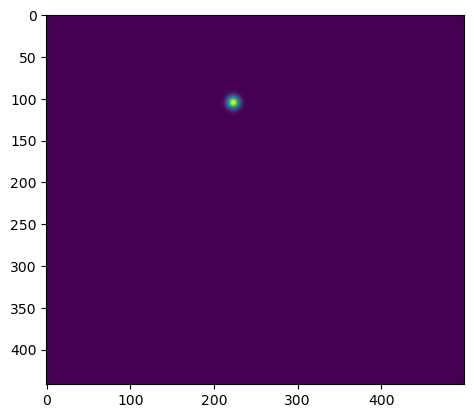

[[0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0.]]


In [21]:
import cv2

def get_label(file_path, label_name_to_num, image_size=None):
    raw_label = get_raw_label(file_path, label_name_to_num, image_size)
    label = cv2.GaussianBlur(raw_label, (0, 0), 5)
    label = label / label.max()
    return label

sample_label = get_label("dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml", label_name_to_num)
plt.imshow(sample_label[:, :, 14])
plt.show()
print(sample_label[220:225, 102: 107, 14])

[[0.69767633 0.77105159 0.81873075 0.83527021 0.81873075]
 [0.77105159 0.85214379 0.90483742 0.92311635 0.90483742]
 [0.81873075 0.90483742 0.96078944 0.98019867 0.96078944]
 [0.83527021 0.92311635 0.98019867 1.         0.98019867]
 [0.81873075 0.90483742 0.96078944 0.98019867 0.96078944]]


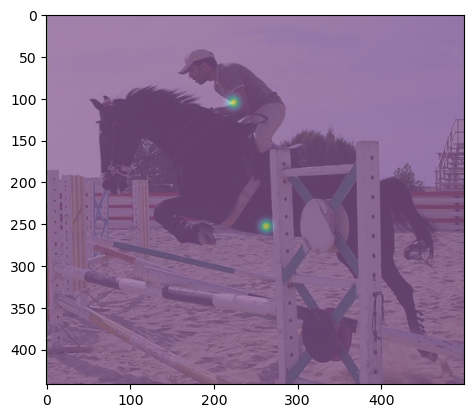

In [22]:

from PIL import Image
plt.imshow(Image.open("dataset/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg"), alpha=0.5)
plt.imshow(sample_label[:, :, 12] +sample_label[:, :, 14], alpha=0.5)
print(sample_label[102: 107,220:225, 14])

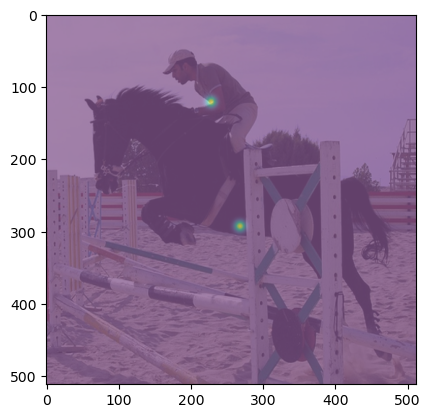

[[0.00020347 0.00027465 0.00035621 0.00044386 0.0005314 ]
 [0.00042646 0.00057566 0.00074659 0.0009303  0.00111378]
 [0.00085878 0.00115923 0.00150344 0.0018734  0.00224287]
 [0.00166156 0.00224287 0.00290884 0.00362464 0.00433948]
 [0.00308872 0.00416933 0.00540733 0.00673795 0.00806679]]


In [25]:
sample_resize_label = get_label(
    "dataset/VOCdevkit/VOC2012/Annotations/2008_000008.xml",
    label_name_to_num,
    (512, 512),
)

plt.imshow(Image.open("dataset/VOCdevkit/VOC2012/JPEGImages/2008_000008.jpg").resize((512, 512)), alpha=0.5)
plt.imshow(sample_resize_label[:, :, 12] +sample_resize_label[:, :, 14], alpha=0.5)
plt.show()
print(sample_resize_label[102: 107,220:225, 14])


In [26]:
TRAIN_TXT = "dataset/VOCdevkit/VOC2012/ImageSets/Main/train.txt"
VAL_TXT = "dataset/VOCdevkit/VOC2012/ImageSets/Main/val.txt"


def get_filenames(txt_path):
    with open(txt_path, "r") as file:
        return [line.replace("\n", "") for line in file.readlines()]


train_filenames = get_filenames(TRAIN_TXT)
print(len(train_filenames))

5717
